Создайте таблицу, содержащую значения посещаемости студентом института. Таблица содержит номер студенческого билета, время его входа, выхода и сгенерированное случайное кодовое число при выходе из вуза.  

In [ ]:
CREATE TABLE attendance (
    attendance_id SERIAL PRIMARY KEY, 
    generated_code VARCHAR(64),
    person_id integer,
    enter_time timestamp,
    exit_time timestamp,
    FOREIGN KEY (person_id) REFERENCES student_ids (student_id)
);


С помощью следующего скрипта заполните таблицу данными. Уменьшил до 100к

In [ ]:
do
$$
DECLARE 
	enter_time timestamp(0);
	exit_time timestamp(0);
	person_id integer; 
	enter_id VARCHAR(64);
BEGIN
	FOR i IN 1..100000 LOOP

-- Генерируем случайную дату в указанном диапазоне

	enter_time := to_timestamp(random() * 
(
						extract(epoch from '2023-12-31'::date) - 
						extract(epoch from '2023-01-01'::date)
					)
					 	+ extract(epoch from '2023-01-01'::date)
					);

-- Генерируем случайный интервал времени, который пробыл в вузе студент (не более 10 часов)

	exit_time := enter_time + (floor(random() * 36000 + 1)*'1 SECOND'::interval);
	
person_id := (
				SELECT student_id FROM students
				ORDER BY random()
				LIMIT 1
			);

	enter_id := md5(random()::text);

    	INSERT INTO attendance(generated_code, person_id, enter_time,exit_time) 
VALUES(enter_id, person_id, enter_time, exit_time);

	END LOOP;	
END
$$;


Добавьте в таблицу attendance одно значение, измерив время данной операции. Далее измерьте время выполнения запроса, выводящего содержимого таблицы в отсортированном виде по столбцу generated_code.

-- Измеряем INSERT
INSERT INTO attendance (generated_code, person_id, enter_time, exit_time)
VALUES (md5(random()::text), 831440, now(), now() + INTERVAL '2 hours');


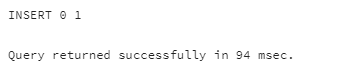

In [ ]:
-- Измеряем SELECT с сортировкой
SELECT * FROM attendance ORDER BY generated_code;


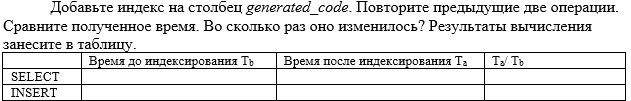

CREATE INDEX idx_generated_code ON attendance(generated_code);


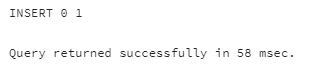

| Операция           | Время до индексирования (Tb), сек | Время после индексирования (Ta), сек | Отношение Ta / Tb |
|--------------------|------------------------------------|---------------------------------------|-------------------|
| INSERT             | 0.094                              | 0.058                                 | 0.617             |
| SELECT ORDER BY    | 1.308                              | 1.142                                 | 0.873             |


Выполните запрос, выводящий все строки таблицы attendance, измерьте время его выполнения. 

In [ ]:
SELECT * FROM attendance;


Добавьте условие, выбрав только все записи, связанные с одним конкретным студентом. 

SELECT * FROM attendance WHERE person_id = 831440;


Создайте индекс на атрибут person_id и повторите эксперименты. Сравните время выполнения операций до создания индекса и после. Объясните полученный результат. 

In [ ]:
CREATE INDEX idx_attendance_person_id ON attendance(person_id);


| Операция             | Время до индексирования (Tb), сек | Время после индексирования (Ta), сек | Отношение Ta / Tb |
|----------------------|------------------------------------|---------------------------------------|-------------------|
| SELECT               | 0.235                              | 0.302                                 | 1,28              |
| SELECT + WHERE       | 0.13                               | 0.118                                 | 0,9        |


select * не выигрывает от индекса.PSQL всё равно читает всю таблицу.

Филтр по person_id быстрее, теперь PSQL использует индексный поиск